In [38]:
import warnings
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Convolution2D,MaxPool2D,Flatten,Dense,GlobalAveragePooling2D,Dropout
from sklearn.metrics import classification_report

import cv2

In [6]:
#### Data Augmentation


datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',validation_split=0.2)
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('./data/new_images',
                  target_size=(192, 192),
                  batch_size=32,
                  class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('./data/new_images',
                target_size=(192, 192),
                batch_size=32,
                class_mode='categorical')



Found 800 images belonging to 3 classes.
Found 800 images belonging to 3 classes.


In [14]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(192, 192, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [15]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy'])



In [16]:
history = model.fit_generator(
train_dataset,
steps_per_epoch=50,
epochs=4,
validation_data=test_dataset,
validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/4
50/50 [==============================] - 208s 4s/step - loss: 0.6289 - categorical_accuracy: 0.7997 - val_loss: 0.6409 - val_categorical_accuracy: 0.8113
Epoch 2/4
50/50 [==============================] - 236s 5s/step - loss: 0.6031 - categorical_accuracy: 0.8135 - val_loss: 0.6318 - val_categorical_accuracy: 0.8113
Epoch 3/4
50/50 [==============================] - 229s 5s/step - loss: 0.5579 - categorical_accuracy: 0.8056 - val_loss: 0.4317 - val_categorical_accuracy: 0.8113
Epoch 4/4
50/50 [==============================] - 232s 5s/step - loss: 0.5803 - categorical_accuracy: 0.8004 - val_loss: 0.3321 - val_categorical_accuracy: 0.8113


In [17]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

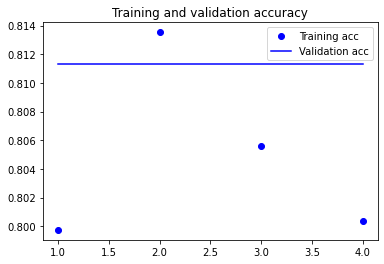

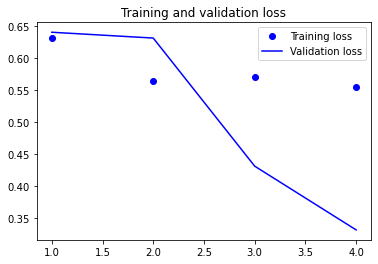

In [18]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Evaluating model

In [25]:
from keras.models import model_from_json

In [22]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()


In [26]:

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
loaded_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
score = loaded_model.evaluate(validation_generator)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
25/25 [==============================] - 24s 971ms/step
categorical_accuracy: 80.75%


In [27]:
predict = loaded_model.predict(validation_generator)

In [30]:
pred_list = []
for pred in predict:
    pred_list.append(np.argmax(pred))

In [34]:
print(classification_report(validation_generator.labels,pred_list))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       646
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00       123

    accuracy                           0.81       800
   macro avg       0.27      0.33      0.30       800
weighted avg       0.65      0.81      0.72       800



C:\Users\mukesh\mystuff\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Feature Engineering

In [ ]:
 #### first task was to transforms an image into a single-channel image. The approach used to achieve this

In [39]:
#convert RGB img to numpy.array
img = cv2.imread('./data/images/GICSD_1_0_3.png')
print ("RGB shape:", img.shape, "\n")
# print(img[0:1], '\n')

#convert to 1x channel image (greyscale)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Grayscale shape:",img_gray.shape)


RGB shape: (192, 192, 3) 

Grayscale shape: (192, 192)


In [40]:
def directory_to_gray(in_dir, out_dir):
    """
    Converts all images in a given directory to 1x channel image.
    Save grayscale images to another directory.
    """
    import cv2, os
    # list files
    filepaths = get_files(in_dir,'png')
    for img in filepaths:
        img_gray = image_to_gray(img)
        #maintain same filename 
        outfile_path = out_dir + '/' + os.path.basename(img)
        cv2.imwrite(outfile_path, img_gray)
        
def list_lowest_dirs(directory):
    lowest_dirs = list()
    for root,dirs,_ in os.walk(directory):
        if not dirs:
            lowest_dirs.append(root)   
    return lowest_dirs